# 1.4 - Stopping Criteria

In [1]:
#@title Install Packages
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(here()))
    
    # library parameters
    from rbig_jax.data import get_classic
    from rbig_jax.plots import plot_info_loss, plot_joint, plot_joint_prob
except ModuleNotFoundError:
    %%capture
    import os
    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", False)

import numpy as onp
from functools import partial

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

<Figure size 432x288 with 0 Axes>

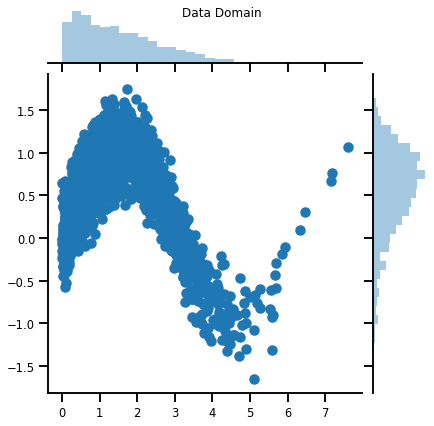

In [3]:
# %%wandb
# get data
n_samples = 2_000
n_features = 2
data = get_classic(n_samples)

# plot data
plt.figure()
sns.jointplot(data[:, 0], data[:, 1])
plt.suptitle('Data Domain')
plt.show()

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

In [4]:
X = np.array(data, dtype=np.float32)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


## Gaussianization

In [5]:
from rbig_jax.transforms.block import get_default_rbig_block

# initialize with default block parameters
fit_transform_func, forward_f, grad_f, inverse_f = get_default_rbig_block(
    n_samples=n_samples)

# optional, compiles the function to make it faster
fit_transform_func_jitted = jax.jit(fit_transform_func)
forward_f_jitted = jax.jit(forward_f)
grad_f_jitted = jax.jit(grad_f)
inverse_f_jitted = jax.jit(inverse_f)

### Fixed Number of Layers

In [50]:
from chex import dataclass

@dataclass
class MaxLoss:
    layer: int
    max_layers: int

In [51]:
def max_condition(state):
    loss_state, x, params = state
    return loss_state.layer <= loss_state.max_layers

In [55]:
%%time

n_layers = 20

params = []
losses = []
ilayer = 0
X_g = X

state = MaxLoss(layer=0, max_layers=n_layers), X_g, params

max_condition(state)

while max_condition(state):
    
    loss_state, x, params = state
    
    # compute 
    X_g, layer_params = fit_transform_func_jitted(X_g)
    
    params.append(layer_params)  
    
    state = MaxLoss(layer=loss_state.layer + 1, max_layers=loss_state.max_layers), X_g, params
    
      

CPU times: user 29.8 ms, sys: 8.06 ms, total: 37.9 ms
Wall time: 11.1 ms


In [ ]:
def max_layer_condition(ilayer, true_fun, false_fun, operand):
    if pred:
        return true_fun(operand)
    else:
        return false_fun(operand)

In [ ]:
def info_change_condition(pred, true_fun, false_fun, operand):
    if pred:
        return true_fun(operand)
    else:
        return false_fun(operand)

In [69]:
init_state = MaxLoss(layer=0, max_layers=n_layers), X_g

def max_condition(state):
    loss_state, x = state
    verdict = lax.cond(True, )
    return loss_state.layer <= loss_state.max_layers

def body(state):
    loss_state, x = state

    x, _ = fit_transform_func_jitted(x)
    
    if loss_state.layer == 1:
        i = 1
    else:
        loss_state.layer == 10
        i = 0
    
    params.append(layer_params)  
    state = MaxLoss(layer=loss_state.layer + 1, max_layers=loss_state.max_layers), x
    
    return state
    
final_state = jax.lax.while_loop(max_condition, body, init_state)

print(final_state[1][:10].shape)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected.

The problem arose with the `bool` function. 

While tracing the function body at <ipython-input-69-551858eab1c5>:7, this concrete value was not available in Python because it depends on the value of the arguments to body at <ipython-input-69-551858eab1c5>:7 at flattened positions [0], and the computation of these values is being staged out (that is, delayed rather than executed eagerly).

You can use transformation parameters such as `static_argnums` for `jit` to avoid tracing particular arguments of transformed functions, though at the cost of more recompiles.

See https://jax.readthedocs.io/en/latest/faq.html#abstract-tracer-value-encountered-where-concrete-value-is-expected-error for more information.

Encountered tracer value: Traced<ShapedArray(bool[])>with<DynamicJaxprTrace(level=1/0)>

(2000, 2)


In [59]:
init_state = MaxLoss(layer=0, max_layers=n_layers), X_g, params

def body(state):
    loss_state, x, params = state

    x, layer_params = fit_transform_func_jitted(x)
    
    params.append(layer_params)  
    state = MaxLoss(layer=loss_state.layer + 1, max_layers=loss_state.max_layers), x, params
    
    return state
    
final_state = jax.lax.while_loop(max_condition, body, init_state)

TypeError: body_fun output and input must have same type structure, got PyTreeDef(tuple, [PyTreeDef(<class '__main__.MaxLoss'>[PyTreeDef(dict[['layer', 'max_layers']], [*,*])], [*,*]),*,PyTreeDef(list, [PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*])])]) and PyTreeDef(tuple, [PyTreeDef(<class '__main__.MaxLoss'>[PyTreeDef(dict[['layer', 'max_layers']], [*,*])], [*,*]),*,PyTreeDef(list, [PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*]),PyTreeDef(<class 'rbig_jax.transforms.block.RBIGBlockParams'>[PyTreeDef(dict[['empirical_pdf', 'quantiles', 'rotation', 'support', 'support_pdf']], [*,*,*,*,*])], [*,*,*,*,*])])]).

<Figure size 432x288 with 0 Axes>

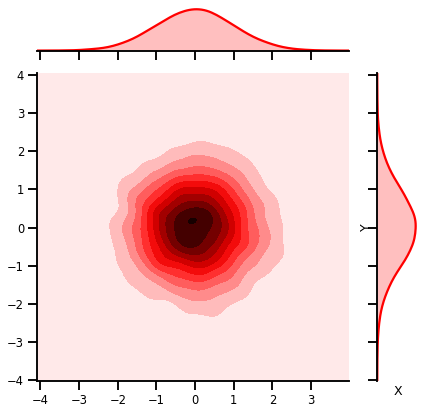

In [56]:
plot_joint(X_g, kind="kde")

## Negative Log-Likelihood

#### Loss Function

In [8]:
@jax.jit
def nll_loss(X_gauss, X_ldj):
    latent_prob = jax.scipy.stats.norm.logpdf(X_g)

    log_prob = (latent_prob + X_ldj).sum(-1)
    return - log_prob.mean()

#### Training

In [9]:
%%time

X_g_ = X
X_ldj = np.zeros_like(X)
nll_losses = []
for iparam in params:

    X_g_, iX_ldj = grad_f_jitted(iparam, X_g_)
    X_ldj += iX_ldj
    
    nll_losses.append(nll_loss(X_g_, X_ldj))
    
chex.assert_tree_all_close(X_g_, X_g)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lax/lax.py:6190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


CPU times: user 1 s, sys: 57.6 ms, total: 1.06 s
Wall time: 900 ms


#### Plot Losses

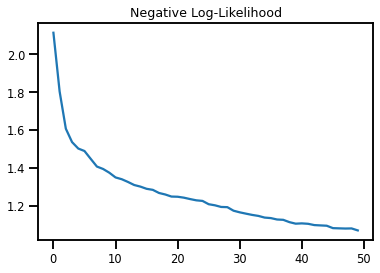

In [10]:

plt.figure()
plt.plot(nll_losses)
plt.title('Negative Log-Likelihood')
plt.show()

### Negative Log-Likelihood (Change per layer)

In [11]:
%%time

X_g_ = X
X_ldj = np.zeros_like(X)
nll_change_losses = []
for iparam in params:

    X_g_, iX_ldj = grad_f_jitted(iparam, X_g_)
    X_ldj += iX_ldj
    
    nll_change_losses.append(nll_loss(X_g_, iX_ldj))
    
chex.assert_tree_all_close(X_g_, X_g)

CPU times: user 165 ms, sys: 35.1 ms, total: 200 ms
Wall time: 43.8 ms


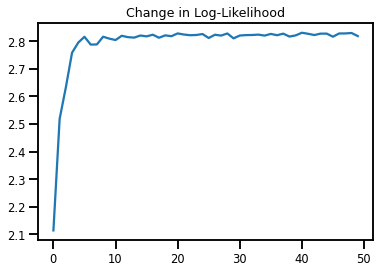

In [12]:
plt.figure()
plt.plot(nll_change_losses)
plt.title('Change in Log-Likelihood')
plt.show()

## Information Loss

#### Loss Function

In [13]:
from rbig_jax.information.total_corr import init_information_reduction_loss

In [14]:
# information reduction loss
info_loss_f = init_information_reduction_loss(n_samples=n_samples, base=2, p=0.1)


loss_f_jitted = jax.jit(info_loss_f)  # much faster!

In [181]:
import chex

@chex.dataclass
class InfoLossState:
    max_layers: int
    ilayer: int
    info_loss: chex.Array
    
def get_minimum_zeroth_element(x: chex.Array, window_size: int = 10) -> int:

    # window for the convolution
    window = np.ones(window_size) / window_size

    # rolling average
    x_cumsum_window = np.convolve(np.abs(x), window, "valid")

    # get minimum zeroth element
    min_idx = int(np.min(np.argwhere(x_cumsum_window == 0.0)[0]))
    return min_idx
    
    
# window for the convolution
zero_tolerance = 20
window = np.ones(zero_tolerance) / zero_tolerance




In [182]:
# initialize state
max_layers = 10_000
ilayer = 0
init_state = InfoLossState(
    max_layers=max_layers,
    ilayer=ilayer,
    info_loss=np.ones(max_layers)#np.array([10.]*20 + [0.0] * 5)#np.ones(max_layers)
)


condition(init_state)

DeviceArray(True, dtype=bool)

#### Training

In [183]:
%%time

n_layers = 50

params = []
info_losses = []
ilayer = 0
X_g = X

# initialize state
max_layers = 50
ilayer = 0
state = InfoLossState(
    max_layers=max_layers,
    ilayer=ilayer,
    info_loss=np.ones(max_layers)
)

while condition(state):
    
    layer_loss = jax.partial(loss_f_jitted, X_before=X_g)
    
    # compute 
    X_g, layer_params = fit_transform_func_jitted(X_g)
    
    # get information reduction
    layer_loss = layer_loss(X_after=X_g)
    
    # update layer loss
    info_losses = jax.ops.index_update(
                state.info_loss, state.ilayer, layer_loss
            )
    state = InfoLossState(
        max_layers=max_layers,
        ilayer=state.ilayer + 1,
        info_loss=info_losses
    )
  
    
info_losses = np.stack(state.info_loss[:state.ilayer])

CPU times: user 546 ms, sys: 59.2 ms, total: 605 ms
Wall time: 395 ms


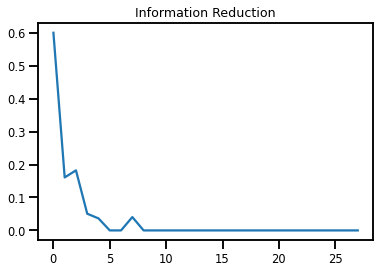

In [184]:
plt.figure()
plt.plot(info_losses)
plt.title('Information Reduction')
plt.show()

#### Total Correlation

In [185]:
total_corr = np.cumsum(info_losses)

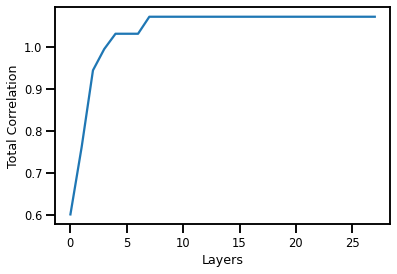

In [186]:
plt.figure()
plt.plot(total_corr)
plt.ylabel('Total Correlation')
plt.xlabel("Layers")
plt.show()

In [187]:
print(f"Total Correlation: {info_losses.sum():.4f}")

Total Correlation: 1.0715


## Optimal Gaussianization

In [ ]:
info_sum = np.sum(np.abs(layers))

In [22]:
%%time

n_layers = 15

params = []
info_losses = []
ilayer = 0
X_g = X

while ilayer < n_layers:
    
    layer_loss = jax.partial(loss_f_jitted, X_before=X_g)
    
    # compute 
    X_g, layer_params = fit_transform_func_jitted(X_g)
    
    info_losses.append(layer_loss(X_after=X_g))
        
    # increment
    ilayer += 1   
    
info_losses = np.stack(info_losses)

CPU times: user 98.1 ms, sys: 27.2 ms, total: 125 ms
Wall time: 35.8 ms


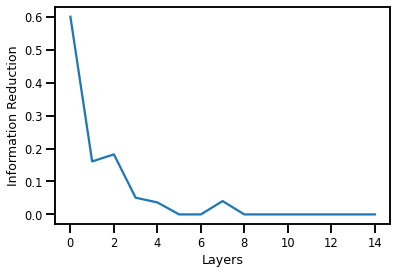

In [24]:
plt.figure()
plt.plot(info_losses)
plt.ylabel('Information Reduction')
plt.xlabel("Layers")
plt.show()